# Simple to start with

Just assume we will use all articles

In [9]:
dump_file = "../../data/wikipedia/iswiki-20240901-pages-articles.xml"

# ---

In [1]:
import xml.etree.ElementTree as ET
import wikitextparser as wtp
from collections import Counter
import pandas as pd
from urllib.parse import quote


class WikiXMLHandler:
    def __init__(self, max_pages=None):
        self.current_page = {}
        self.pages_processed = 0
        self.max_pages = max_pages
        self.page_count = Counter()
        self.metadata = []

    def parse(self, xml_file):
        for event, elem in ET.iterparse(xml_file, events=("start", "end")):
            if event == "end" and elem.tag.endswith("page"):
                self.process_page(elem)
                elem.clear()
                if self.max_pages and self.pages_processed >= self.max_pages:
                    break

    def process_page(self, elem):
        ns = elem.find("./{*}ns")
        if ns is not None and ns.text == "0":  # Main articles
            title = elem.findtext("./{*}title")
            text = elem.findtext(".//{*}text")
            page_id = elem.findtext("./{*}id")
            timestamp = elem.findtext(".//{*}timestamp")

            if text and not text.lower().startswith("#redirect"):
                parsed = wtp.parse(text)

                plain_text = parsed.plain_text()
                word_count = len(plain_text.split())
                outlinks = parsed.wikilinks
                outlink_count = len(outlinks)
                categories = [
                    link.title.strip()
                    for link in outlinks
                    if link.title.startswith("Category:")
                ]
                templates = parsed.templates
                external_links = parsed.external_links

                # Generate URL
                url = f"https://is.wikipedia.org/wiki/{quote(title.replace(' ', '_'))}"

                self.metadata.append(
                    {
                        "page_id": page_id,
                        "title": title,
                        "url": url,
                        "word_count": word_count,
                        "outlink_count": outlink_count,
                        "category_count": len(categories),
                        "categories": "|".join(categories),
                        "template_count": len(templates),
                        "external_link_count": len(external_links),
                        "last_modified": timestamp,
                        "processed_text": plain_text,  # This is the text we'll use for embedding
                        "raw_text": text,  # Original wikitext, in case we need it later
                    }
                )

                self.page_count["content"] += 1
            else:
                self.page_count["redirect"] += 1

            self.pages_processed += 1
            if self.pages_processed % 10000 == 0:
                print(
                    f"Processed {self.pages_processed} pages "
                    f"(Content: {self.page_count['content']}, "
                    f"Redirects: {self.page_count['redirect']})"
                )


def process_wikipedia_dump(file_path, max_pages=None):
    handler = WikiXMLHandler(max_pages)
    handler.parse(file_path)

    print(f"Total pages processed: {handler.pages_processed}")
    print(f"Content pages: {handler.page_count['content']}")
    print(f"Redirect pages: {handler.page_count['redirect']}")

    return pd.DataFrame(handler.metadata)


# Usage
dump_file = "../../data/wikipedia/iswiki-20240901-pages-articles.xml"
df = process_wikipedia_dump(dump_file, max_pages=None)

print(len(df))
df.head()

Processed 1000 pages (Content: 887, Redirects: 113)
Processed 2000 pages (Content: 1746, Redirects: 254)
Processed 3000 pages (Content: 2505, Redirects: 495)
Processed 4000 pages (Content: 2558, Redirects: 1442)
Processed 5000 pages (Content: 3099, Redirects: 1901)
Processed 6000 pages (Content: 4052, Redirects: 1948)
Processed 7000 pages (Content: 5033, Redirects: 1967)
Processed 8000 pages (Content: 6033, Redirects: 1967)
Processed 9000 pages (Content: 7032, Redirects: 1968)
Processed 10000 pages (Content: 8032, Redirects: 1968)
Processed 11000 pages (Content: 8935, Redirects: 2065)
Processed 12000 pages (Content: 9895, Redirects: 2105)
Processed 13000 pages (Content: 10867, Redirects: 2133)
Processed 14000 pages (Content: 11846, Redirects: 2154)
Processed 15000 pages (Content: 12731, Redirects: 2269)
Processed 16000 pages (Content: 13659, Redirects: 2341)
Processed 17000 pages (Content: 14627, Redirects: 2373)
Processed 18000 pages (Content: 15614, Redirects: 2386)
Processed 19000 p

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text
0,3,Finnland,https://is.wikipedia.org/wiki/Finnland,4306,553,0,,110,47,2024-04-18T10:18:03Z,"\nFinnland (finnska Suomi; sænska: Finland), f...",{{Land\n| nafn = Lýðveldið Finnland\n| nafn_á_...
1,4,Forsíða,https://is.wikipedia.org/wiki/Fors%C3%AD%C3%B0a,28,5,0,,11,0,2021-01-02T00:52:18Z,\n\n\n\n\n\n\n\nGrein mánaðarins\n\nEldri grei...,"<templatestyles src=""Template:Forsíða/styles.c..."
2,6,Reykjavík,https://is.wikipedia.org/wiki/Reykjav%C3%ADk,2323,309,0,,51,41,2024-04-09T12:51:22Z,"\n\nReykjavík er höfuðborg Íslands, fjölmennas...",{{Um|höfuðborg Íslands|aðrar merkingar orðsins...
3,7,Svíþjóð,https://is.wikipedia.org/wiki/Sv%C3%AD%C3%BEj%...,3025,360,0,,44,56,2024-08-12T16:35:20Z,"\n\nSvíþjóð (sænska: Sverige), formlegt heiti ...",{{Land \n|nafn = Konungsríkið Svíþjóð\n|nafn_á...
4,591,Danmörk,https://is.wikipedia.org/wiki/Danm%C3%B6rk,4711,489,0,,55,58,2024-07-18T11:56:58Z,\nDanmörk (danska: Danmark; ) er land í Norður...,{{Land\n| nafn = Konungsríkið Danmörk\n| nafn_...


### time per page 


In [188]:
total_time_s = 60
n_pages_parsed = 93598

time_per_page_s = total_time_s / n_pages_parsed

print(f"Time per page: {time_per_page_s * 1000:.2f} ms")

print("Time per M pages: ", (time_per_page_s * 1e6 / 60), "min")
print("Time for 10M pages: ", (time_per_page_s * 1e7 / 60), "min")
print("Time for 20M pages: ", (time_per_page_s * 2e7 / 60), "min")

Time per page: 0.64 ms
Time per M pages:  10.683988974123379 min
Time for 10M pages:  106.83988974123379 min
Time for 20M pages:  213.67977948246758 min


In [2]:
df.word_count.describe()

count    86163.000000
mean       175.182990
std        428.435677
min          1.000000
25%          3.000000
50%         50.000000
75%        178.000000
max      14782.000000
Name: word_count, dtype: float64

In [3]:
df[df.word_count < 5]

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text
19,621,Lúther,https://is.wikipedia.org/wiki/L%C3%BAther,2,1,0,,0,0,2019-06-17T14:50:09Z,#TILVÍSUNMarteinn Lúther,#TILVÍSUN[[Marteinn Lúther]]
47,720,Líffæri,https://is.wikipedia.org/wiki/L%C3%ADff%C3%A6ri,2,1,0,,0,0,2005-10-30T14:25:45Z,#tilvísun Líffærakerfi,#tilvísun [[Líffærakerfi]]
59,737,Byggingarþrep líkamans,https://is.wikipedia.org/wiki/Byggingar%C3%BEr...,1,1,0,,0,0,2023-05-07T12:28:11Z,#TILVÍSUNLíkami,#TILVÍSUN[[Líkami]]
96,785,Harðmæli,https://is.wikipedia.org/wiki/Har%C3%B0m%C3%A6li,2,1,0,,0,0,2019-01-23T20:27:21Z,#TILVÍSUNÍslenskar mállýskur#Harðmæli,#TILVÍSUN[[Íslenskar mállýskur#Harðmæli]]
106,800,Kýrilískt letur,https://is.wikipedia.org/wiki/K%C3%BDril%C3%AD...,3,1,0,,0,0,2008-07-27T03:32:48Z,#tilvísun Kýrillískt stafróf,#tilvísun [[Kýrillískt stafróf]]
...,...,...,...,...,...,...,...,...,...,...,...,...
86142,182230,Geimferðarbúningur,https://is.wikipedia.org/wiki/Geimfer%C3%B0arb...,1,1,0,,0,0,2024-08-28T09:17:57Z,#TILVÍSUNGeimbúningur,#TILVÍSUN[[Geimbúningur]]
86145,182233,Balearica regulorum,https://is.wikipedia.org/wiki/Balearica_regulorum,1,1,0,,0,0,2024-08-28T11:52:32Z,#TILVÍSUNGrákrónutrana,#TILVÍSUN[[Grákrónutrana]]
86147,182235,Nasua narica,https://is.wikipedia.org/wiki/Nasua_narica,1,1,0,,0,0,2024-08-28T12:58:28Z,#TILVÍSUNHvítnefsbjörn,#TILVÍSUN[[Hvítnefsbjörn]]
86151,182240,Sven Göran Eriksson,https://is.wikipedia.org/wiki/Sven_G%C3%B6ran_...,3,1,0,,0,0,2024-08-28T15:05:02Z,#tilvísun Sven-Göran Eriksson,#tilvísun [[Sven-Göran Eriksson]]


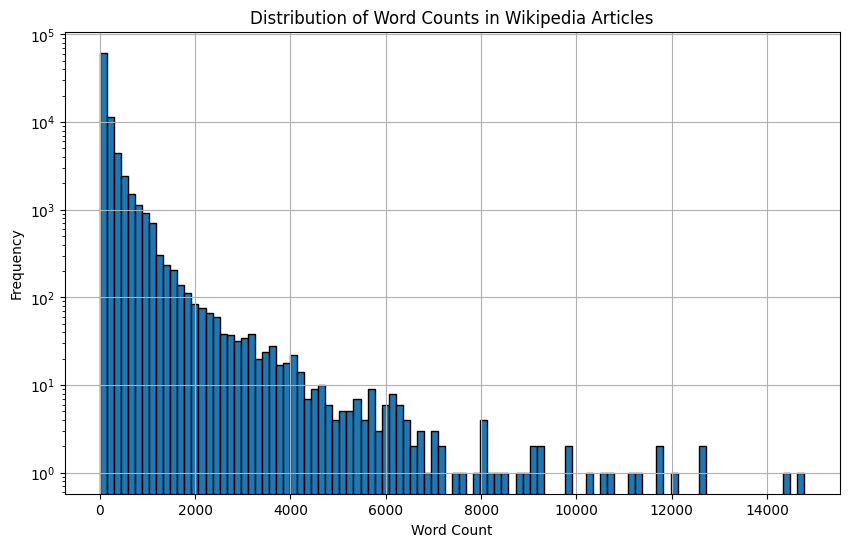

In [4]:
import matplotlib.pyplot as plt

# Plotting the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(df["word_count"], bins=100, edgecolor="black", log=True)
plt.title("Distribution of Word Counts in Wikipedia Articles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)

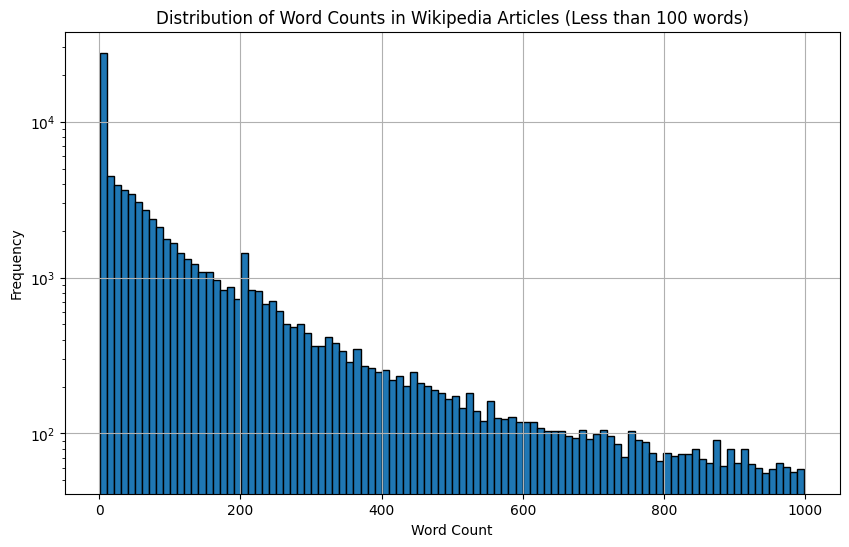

In [5]:
# word count histogram for articles with less than n words
cutoff = 1000

plt.figure(figsize=(10, 6))
plt.hist(
    df[df.word_count < cutoff]["word_count"], bins=100, edgecolor="black", log=True
)
plt.title("Distribution of Word Counts in Wikipedia Articles (Less than 100 words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)

## Can safely remove articles with few words

Just need to decide on a cutoff

In [6]:
df_all = df.copy()

df = df[df.word_count > 100]

# example article with 11 words:
# https://is.wikipedia.org/wiki/N%C3%A1ttfarar

print("len(df_all): ", len(df_all))
print("len(df): ", len(df))
df.sort_values("word_count", ascending=True).head(2)

len(df_all):  86163
len(df):  30938


,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text
33535,75656,NorðurÍs,https://is.wikipedia.org/wiki/Nor%C3%B0ur%C3%8Ds,101,7,0,,1,2,2009-04-22T20:51:12Z,NorðurÍs hf. er íslenskt fyrirtæki sem var sto...,'''NorðurÍs hf.''' er íslenskt fyrirtæki sem v...
12373,29325,Haífa,https://is.wikipedia.org/wiki/Ha%C3%ADfa,101,22,0,,6,1,2024-04-17T22:33:46Z,\n\nHaífa (hebreska: חיפה) er hafnarborg í Ísr...,{{Byggð\n| nafn = Haífa\n|...


# Now embed each article, and store the vectors in the dataframe

In [7]:
import sys

sys.path.append("../../src")

# from vectordb.embedding.embedder import Embedder
from vectordb import chunk_utils

# embedder = Embedder()

# embed each article, and store the vectors in the dataframe
# df['vector'] = embedder.embed(df.processed_text.tolist())
df["processed_text"] = df["processed_text"].str.strip()

In [10]:
df["split_text"] = df["processed_text"].apply(
    lambda x: chunk_utils.split_text(x, chunk_size=2000, chunk_overlap=100)
)

In [11]:
df["n_chunks"] = df["split_text"].apply(lambda x: len(x))

In [16]:
# get list of chunk word counts
df["chunk_word_counts"] = df["split_text"].apply(
    lambda x: [len(chunk.split(" ")) for chunk in x]
)

df = df.sort_values("n_chunks", ascending=False)


# print sequence of for chunks of len < 10 words
# as a single string for each sequence of consecutive chunks with len < 10 words
# concatenated with " | "
# for the first article
consecutive_chunks = []
for chunk, n_words in zip(df.split_text.iloc[0], df.chunk_word_counts.iloc[0]):
    if n_words < 10:
        consecutive_chunks.append(chunk)
    else:
        if len(consecutive_chunks) > 0:
            print(" | ".join(consecutive_chunks))
            print("\n---\n")
            consecutive_chunks = []

Þáttur Nr. | # | Titill | Sýnt í USA | Bandarískir áhorfendur (í milljónum) | 1 | 1 | Pilot | 19. september 2007 | 3.50

---

2 | 2 | The Wild Brunch | 26. september 2007 | 2.48

---

3 | 3 | Poison Ivy | 3. október 2007 | 2.75

---

Titillinn kemur frá kvikmyndinni Poison Ivy frá árinu 1992. | 4 | 4 | Bad News Blair | 10. október 2007 | 2.80

---

5 | 5 | Dare Devil | 17. október 2007 | 2.41

---

Titillinn kemur frá teiknimyndasögunum Daredevil. | 6 | 6 | The Handmaiden's Tale | 24. október 2007 | 2.54

---

Titillinn kemur frá bókinni The Handmaid's Tale frá 1985. | 7 | 7 | Victor, Victrola | 7. nóvember 2007 | 2.52

---

Titillinn kemur frá myndinni Victor Victoria frá 1982. | 8 | 8 | Seventeen Candles | 14. nóvember 2007 | 2.95

---

Titillinn kemur frá kvikmyndininni Sixteen Candles frá 1984. | 9 | 9 | Blair Waldorf Mus Pie! | 28. nóvember 2007 | 2.93

---

10 | 10 | Hi, Society | 5. desember 2007 | 2.44

---

Titillinn kemur frá kvikmyndinni High Society frá 1956. | 11 | 11 | Ro

# Now try to use minimum chunk size (in words)

In [172]:
import importlib

importlib.reload(chunk_utils)
pd.set_option("display.max_colwidth", 150)

df["split_text_min_words"] = df["processed_text"].apply(
    lambda x: chunk_utils.split_text(
        x,
        chunk_size=1250,
        chunk_overlap=100,
        discard_chunk_n_words_cutoff=10,  # discard chunks with less than 10 words
        clean_whitespace=True,
        clean_html=True,
        min_words_per_chunk=30,
    )
)
df["n_chunks_min_words"] = df["split_text_min_words"].apply(lambda x: len(x))
df["chunk_word_counts_min_words"] = df["split_text_min_words"].apply(
    lambda x: [len(chunk.split()) for chunk in x]
)

df = df.sort_values("n_chunks_min_words", ascending=False)

df.head(2)

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text,split_text,n_chunks,chunk_word_counts,split_text_min_words,n_chunks_min_words,chunk_word_counts_min_words,min_chunk_size,largest_chunk_size
11702,27958,Knattspyrnufélagið Valur,https://is.wikipedia.org/wiki/Knattspyrnuf%C3%A9lagi%C3%B0_Valur,14437,492,0,,259,153,2024-08-23T09:57:04Z,"Valur er íslenskt íþróttafélag sem hefur aðstöðu að Hlíðarenda. Valur teflir fram liðum í knattspyrnu, handknattleik og körfuknattleik og leika al...","{{Knattspyrnulið\n| Fullt nafn = Knattspyrnufélagið Valur\n| Mynd = [[Mynd:Valur.svg|250x250dp]]\n| Gælunafn = Valsarar, Hlíðarendapiltar\n| Stofn...","[Valur er íslenskt íþróttafélag sem hefur aðstöðu að Hlíðarenda. Valur teflir fram liðum í knattspyrnu, handknattleik og körfuknattleik og leika a...",71,"[275, 168, 332, 199, 331, 263, 265, 183, 226, 188, 322, 237, 236, 264, 270, 319, 79, 261, 131, 304, 239, 199, 224, 226, 117, 325, 46, 117, 284, 25...","[Valur er íslenskt íþróttafélag sem hefur aðstöðu að Hlíðarenda. Valur teflir fram liðum í knattspyrnu, handknattleik og körfuknattleik og leika a...",108,"[31, 182, 161, 80, 209, 211, 127, 126, 205, 150, 115, 113, 152, 183, 243, 189, 240, 100, 144, 94, 207, 44, 173, 95, 202, 63, 199, 214, 104, 156, 1...",30,202
32337,73089,Úrslit Gettu betur,https://is.wikipedia.org/wiki/%C3%9Arslit_Gettu_betur,12644,1395,0,,1,2,2024-03-21T22:06:54Z,Þetta er listi yfir úrslit í keppninni Gettu betur.\n\n== 2021-2030 ==\n=== 2024 ===\n25 lið skráðu sig til keppni. Dómarar og spurningahöfundar e...,{{DISPLAYTITLE:Úrslit <i>Gettu betur</i>}}\n\nÞetta er listi yfir úrslit í keppninni ''[[Gettu betur]]''.\n\n== 2021-2030 ==\n=== [[2024]] ===\n25...,[Þetta er listi yfir úrslit í keppninni Gettu betur.\n\n== 2021-2030 ==\n=== 2024 ===\n25 lið skráðu sig til keppni. Dómarar og spurningahöfundar ...,58,"[190, 258, 233, 159, 263, 262, 257, 191, 234, 259, 176, 252, 262, 256, 224, 251, 162, 249, 148, 222, 188, 273, 163, 252, 153, 290, 267, 209, 250, ...",[Þetta er listi yfir úrslit í keppninni Gettu betur.\n\n== 2021-2030 ==\n=== 2024 ===\n25 lið skráðu sig til keppni. Dómarar og spurningahöfundar ...,92,"[124, 85, 168, 110, 84, 172, 175, 149, 138, 83, 171, 82, 106, 177, 174, 185, 121, 87, 163, 115, 80, 166, 189, 137, 143, 76, 177, 177, 169, 178, 10...",30,169


In [173]:
import math

c = df.iloc[0].chunk_word_counts_min_words

# print some stats about c
print("mean: ", sum(c) / len(c))
print("max: ", max(c))
print("min: ", min(c))
print("std: ", math.sqrt(sum((x - sum(c) / len(c)) ** 2 for x in c) / len(c)))

mean:  136.80555555555554
max:  248
min:  31
std:  54.13143441068254


In [174]:
for i, chunk in enumerate(df.split_text_min_words.iloc[0]):
    if len(chunk.strip().split()) < 63:
        print(chunk)
        print(chunk.strip().split())
        print(i)
        print("---")

        break

Valur er íslenskt íþróttafélag sem hefur aðstöðu að Hlíðarenda. Valur teflir fram liðum í knattspyrnu, handknattleik og körfuknattleik og leika allir meistaraflokkar Vals í efstu deild bæði í karla- og kvennaflokki.
['Valur', 'er', 'íslenskt', 'íþróttafélag', 'sem', 'hefur', 'aðstöðu', 'að', 'Hlíðarenda.', 'Valur', 'teflir', 'fram', 'liðum', 'í', 'knattspyrnu,', 'handknattleik', 'og', 'körfuknattleik', 'og', 'leika', 'allir', 'meistaraflokkar', 'Vals', 'í', 'efstu', 'deild', 'bæði', 'í', 'karla-', 'og', 'kvennaflokki.']
0
---


### Smallest chunk

In [175]:
# find the smallest chunk across all articles
# print the article title and url

df["min_chunk_size"] = df["split_text_min_words"].apply(
    lambda x: min([len(chunk.split()) for chunk in x])
)
df.sort_values(["min_chunk_size", "word_count"], ascending=[True, True]).head(3)

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text,split_text,n_chunks,chunk_word_counts,split_text_min_words,n_chunks_min_words,chunk_word_counts_min_words,min_chunk_size,largest_chunk_size
73141,160969,FC Dinamo Minsk,https://is.wikipedia.org/wiki/FC_Dinamo_Minsk,146,7,0,,2,13,2023-03-23T02:25:55Z,FC Dinamo Minsk er Hvít-rússneskt knattspyrnufélag með aðsetur í Minsk. Dinamo Minsk er næst sigursælasta félag Hvíta-Rússlands á eftir BATE Bori...,{{Knattspyrnulið\n| Fullt nafn = FK Dynama Minsk ''(FK Dynama Minsk)''\n| Mynd = \n| Gælunafn = \t\n| Stytt nafn = \n| Stofnað = 1927\n| Leikvöllu...,[FC Dinamo Minsk er Hvít-rússneskt knattspyrnufélag með aðsetur í Minsk. Dinamo Minsk er næst sigursælasta félag Hvíta-Rússlands á eftir BATE Bor...,1,[142],[FC Dinamo Minsk er Hvít-rússneskt knattspyrnufélag með aðsetur í Minsk. Dinamo Minsk er næst sigursælasta félag Hvíta-Rússlands á eftir BATE Bor...,2,"[119, 30]",30,78
33817,76171,Efnarannsóknastofa landsins,https://is.wikipedia.org/wiki/Efnaranns%C3%B3knastofa_landsins,166,20,0,,2,0,2009-05-07T23:19:39Z,"Efnarannsóknastofa landsins, einnig nefnd Rannsóknastofa landsins, Rannsóknastofan eða (eftir 1918) Efnarannsóknastofa ríkisins var stofnuð árið 1...","'''Efnarannsóknastofa landsins''', einnig nefnd '''Rannsóknastofa landsins''', '''Rannsóknastofan''' eða (eftir [[1918]]) '''Efnarannsóknastofa rí...","[Efnarannsóknastofa landsins, einnig nefnd Rannsóknastofa landsins, Rannsóknastofan eða (eftir 1918) Efnarannsóknastofa ríkisins var stofnuð árið ...",1,[163],"[Efnarannsóknastofa landsins, einnig nefnd Rannsóknastofa landsins, Rannsóknastofan eða (eftir 1918) Efnarannsóknastofa ríkisins var stofnuð árið ...",2,"[30, 136]",30,143
18631,42561,Reykjavíkurlistinn,https://is.wikipedia.org/wiki/Reykjav%C3%ADkurlistinn,173,20,0,,1,0,2020-12-21T10:29:21Z,"thumb|right|Merki Reykjavíkurlistans \nReykjavíkurlistinn, R-listinn, var sameiginlegur framboðslisti félagshyggjuflokkanna í Reykjavík í þrennum ...","[[Mynd:Reykjavíkurlistinn.JPG|thumb|right|Merki Reykjavíkurlistans]] \n'''Reykjavíkurlistinn''', R-listinn, var sameiginlegur framboðslisti [[féla...","[thumb|right|Merki Reykjavíkurlistans \nReykjavíkurlistinn, R-listinn, var sameiginlegur framboðslisti félagshyggjuflokkanna í Reykjavík í þrennum...",1,[161],"[thumb|right|Merki Reykjavíkurlistans\nReykjavíkurlistinn, R-listinn, var sameiginlegur framboðslisti félagshyggjuflokkanna í Reykjavík í þrennum ...",2,"[143, 30]",30,118


In [176]:
idx = 0
df = df.sort_values(["min_chunk_size", "word_count"], ascending=[True, True])

print(df.iloc[idx].title)

for i, chunk in enumerate(df.split_text_min_words.iloc[idx]):
    if len(chunk.strip().split()) < 31:
        print(chunk)
        print(chunk.strip().split())
        print(i)
        print("---")

        break

FC Dinamo Minsk
== Titlar ==

*Hvít-rússneska úrvalsdeildin:7

*1992, 1992–93, 1993–94, 1994–95, 1995, 1997, 2004

*Sovéska úrvalsdeildin:1
*1982

*Hvít-rússneska bikarkeppnin:3

*1992, 1993–94, 2002–03

== Tenglar ==
* https://dinamo-minsk.by/

== Heimildir ==

Flokkur:Hvít-rússnesk knattspyrnufélög
['==', 'Titlar', '==', '*Hvít-rússneska', 'úrvalsdeildin:7', '*1992,', '1992–93,', '1993–94,', '1994–95,', '1995,', '1997,', '2004', '*Sovéska', 'úrvalsdeildin:1', '*1982', '*Hvít-rússneska', 'bikarkeppnin:3', '*1992,', '1993–94,', '2002–03', '==', 'Tenglar', '==', '*', 'https://dinamo-minsk.by/', '==', 'Heimildir', '==', 'Flokkur:Hvít-rússnesk', 'knattspyrnufélög']
1
---


### Do the largest chnks make sense?

Do they have too much information per chunk, as to make  
the embedding search less effective? (too much noise)

In [177]:
df["largest_chunk_size"] = df["split_text_min_words"].apply(
    lambda x: max([len(chunk.split()) for chunk in x])
)

df.sort_values("largest_chunk_size", ascending=False).head(3)

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text,split_text,n_chunks,chunk_word_counts,split_text_min_words,n_chunks_min_words,chunk_word_counts_min_words,min_chunk_size,largest_chunk_size
8750,21186,Afbrigði latneska stafrófsins,https://is.wikipedia.org/wiki/Afbrig%C3%B0i_latneska_stafr%C3%B3fsins,1989,515,0,,0,0,2024-01-09T10:19:57Z,"Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstafi...","Það eru til mörg '''afbrigði latneska stafrófsins''', þess [[stafróf|stafrófs]] sem notað til að rita flest þeirra [[tungumál|tungumála]] sem nú e...","[Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstaf...",5,"[279, 243, 210, 253, 11]","[Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstaf...",7,"[207, 293, 343, 333, 398, 324, 113]",113,398
62606,143550,Listi yfir ár,https://is.wikipedia.org/wiki/Listi_yfir_%C3%A1r,5798,3038,0,,0,0,2018-04-24T09:12:33Z,Þetta er síða með lista yfir ár.\n__TOC__\n\n==3. árþúsundið==\n===21. öldin===\n:2100 · 2099 · 2098 · 2097 · 2096 · 2095 · 2094 · 2093 · 2092 · 2...,"Þetta er síða með lista yfir '''[[ár]]'''.\n<div style=""clear: right; margin-bottom: .5em; float: right; padding: .5em 0 .8em 1.4em; background: n...",[Þetta er síða með lista yfir ár.\n__TOC__\n\n==3. árþúsundið==\n===21. öldin===\n:2100 · 2099 · 2098 · 2097 · 2096 · 2095 · 2094 · 2093 · 2092 · ...,12,"[371, 363, 363, 363, 363, 545, 544, 544, 547, 547, 547, 372]",[Þetta er síða með lista yfir ár.\n__TOC__\n\n==3. árþúsundið==\n===21. öldin===\n:2100 · 2099 · 2098 · 2097 · 2096 · 2095 · 2094 · 2093 · 2092 · ...,21,"[202, 194, 192, 192, 192, 192, 192, 192, 192, 192, 192, 386, 384, 384, 384, 384, 389, 386, 386, 386, 205]",192,389
33145,74939,Söngvakeppni evrópskra sjónvarpsstöðva 2009,https://is.wikipedia.org/wiki/S%C3%B6ngvakeppni_evr%C3%B3pskra_sj%C3%B3nvarpsst%C3%B6%C3%B0va_2009,3818,347,0,,55,0,2024-05-06T00:44:03Z,Söngvakeppni evrópskra sjónvarpsstöðva 2009 var 54. Eurovisionkeppnin. Hún var haldin 12. - 16. maí 2009 í Olympic Indoor Arena í Moskvu í Rússlan...,{{Söngvakeppni\n| ár = 2009\n| þema = \n| mynd = Esc moscow 2009.png\n| mynd_stærð = 220px\n| undanúrs...,[Söngvakeppni evrópskra sjónvarpsstöðva 2009 var 54. Eurovisionkeppnin. Hún var haldin 12. - 16. maí 2009 í Olympic Indoor Arena í Moskvu í Rússla...,18,"[305, 249, 150, 1158, 1071, 940, 123, 686, 1010, 661, 728, 69, 1119, 388, 5, 752, 712, 1]",[Söngvakeppni evrópskra sjónvarpsstöðva 2009 var 54. Eurovisionkeppnin. Hún var haldin 12. - 16. maí 2009 í Olympic Indoor Arena í Moskvu í Rússla...,20,"[174, 175, 173, 191, 185, 170, 77, 127, 172, 181, 338, 62, 347, 115, 71, 209, 36, 346, 386, 344]",36,386


In [178]:
idx = 2000

df = df.sort_values("largest_chunk_size", ascending=False)

# find the largest chunk in the article
max_chunk_size = df.largest_chunk_size.iloc[idx]

print(df.iloc[idx].title)
print(df.iloc[idx].url)
print("--")

for i, chunk in enumerate(df.split_text_min_words.iloc[idx]):
    if len(chunk.strip().split()) == max_chunk_size:
        print(chunk)
        print(i)
        print("---")
        break

Lúdó og Stefán - Lúdó og Stefán
https://is.wikipedia.org/wiki/L%C3%BAd%C3%B3_og_Stef%C3%A1n_-_L%C3%BAd%C3%B3_og_Stef%C3%A1n
--
Lúdó og Stefán - Lúdó og Stefán  er 33 snúninga LP hljómplata gefin út af SG - hljómplötum árið 1976. Á henni syngur Lúdó og Stefán dægurlög. Jón Sigurðsson útsetti og stjórnaði hljóðfæraleik við hljóðritun. Hljóðritun fór fram hjá Tóntækni h.f. Tæknimaður var Sigurður Árnason, sem jafnframt annaðist hljóðblöndun ásamt Lúdó og Stefáni.
==Lagalisti==
#Gudda Jóns - Lag - texti: Hank Williams — Þorsteinn Eggertsson - Stefán Jónsson syngur
#Átján rauðar rósir - Lag - texti: Bobby Darin — Iðunn Steinsdóttir -  Stefán og Berti syngja
#Nóaflóðið - Lag - texti: Harry Warren  — Ómar Ragnarsson - Berti Möller svngur
#Gullið á Raufarhöfn - Lag - texti: Fats Domino — Þorsteinn Eggertsson - Stefán syngur
#Vertu sæl, María - Lag - texti: Gene Pitney — Jónas Friðrik - Stefán og Berti syngja
#Ég er glataður án þín  - Lag - texti: Paul Anka — Ómar Ragnarsson - Stefán syngur
#Ól

## Now analyze how the embedding would go

I.e. how many vectors we would need (one per chunk)

In [179]:
df.head(1)

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,raw_text,split_text,n_chunks,chunk_word_counts,split_text_min_words,n_chunks_min_words,chunk_word_counts_min_words,min_chunk_size,largest_chunk_size
8750,21186,Afbrigði latneska stafrófsins,https://is.wikipedia.org/wiki/Afbrig%C3%B0i_latneska_stafr%C3%B3fsins,1989,515,0,,0,0,2024-01-09T10:19:57Z,"Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstafi...","Það eru til mörg '''afbrigði latneska stafrófsins''', þess [[stafróf|stafrófs]] sem notað til að rita flest þeirra [[tungumál|tungumála]] sem nú e...","[Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstaf...",5,"[279, 243, 210, 253, 11]","[Það eru til mörg afbrigði latneska stafrófsins, þess stafrófs sem notað til að rita flest þeirra tungumála sem nú eru töluð. Það hefur 26 bókstaf...",7,"[207, 293, 343, 333, 398, 324, 113]",113,398


In [180]:
# df.n_chunks_min_words.sum()
print(f"Total number of chunks: {df.n_chunks_min_words.sum():,}")

Total number of chunks: 100,410
